# Language Classification Feature Engineering
Generate character trigram features for language classification model
<br>
<b>Dataset:</b> https://downloads.tatoeba.org/exports/

In [1]:
#imports
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [2]:
import pandas as pd

#Read in full dataset
data = pd.read_csv('../data/sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

#Filter by text length
len_cond = [True if 20<=len(s)<=200 else False for s in data['text']]
data = data[len_cond]

#Filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100)
    data_trim = data_trim.append(lang_trim)

#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

train = data_shuffle[0:210000]
valid = data_shuffle[210000:270000]
test = data_shuffle[270000:300000]

In [3]:
#Save train, valid, test split
# train.to_csv('../data/train.csv')
# valid.to_csv('../data/valid.csv')
# test.to_csv('../data/test.csv')

## Feature engineering 

In [3]:
train = pd.read_csv("../data/train.csv",index_col =0)
valid = pd.read_csv("../data/valid.csv",index_col =0)
test = pd.read_csv("../data/test.csv",index_col =0)
print(len(train),len(valid),len(test))
train.head()

210000 60000 30000


,lang,text
341834,fra,"Pour aggraver les choses, il commença à pleuvoir."
1108027,fra,J'ai tellement faim.
1829725,por,Nunca mais falei com ela.
3583008,ita,Ogni settimana ce n'è una nuova.
406553,por,Com certeza ele vem.


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def get_trigrams(corpus,n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus)
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names()
    
    return feature_names


In [5]:
#obtain trigrams from each language
features = {}
features_set = set()

for l in lang:
    
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

In [6]:
len(features['eng'])

200

In [7]:
#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [8]:
print(len(train_feat.columns))
train_feat

663


,não,onn,ele,e a,li,out,ett,su,t w,pas,...,", d",es,r e,me,hab,sa,and,hen,tte,any
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
209997,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
209998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

train_feat

,não,onn,ele,e a,li,out,ett,su,t w,pas,...,es,r e,me,hab,sa,and,hen,tte,any,lang
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,fra
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,fra
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,por
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,ita
4,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,por
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,spa
209996,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,ita
209997,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.1,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,deu
209998,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,deu


In [10]:
#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])


In [11]:
print(len(valid_feat.columns),len(test_feat.columns))
print(len(train_feat),len(valid_feat),len(test_feat))

664 664
210000 60000 30000


In [133]:
#Save train, valid, test split
# train_feat.to_csv('../data/train_feat.csv')
# valid_feat.to_csv('../data/valid_feat.csv')
# test_feat.to_csv('../data/test_feat.csv')

## Data Exploration

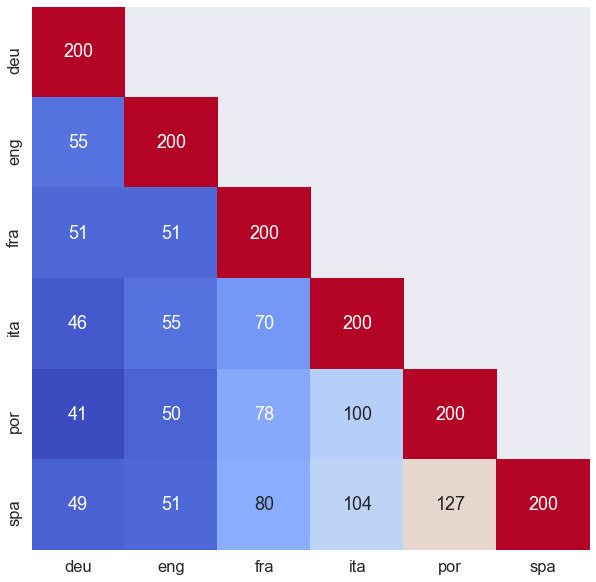

In [12]:
#Calculate number of shared trigrams
labels = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']

mat = []
for i in labels:
    vec = []
    for j in labels:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2] 
        vec.append(len(intersec))
    mat.append(vec)

#Plot heatmap
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix_df = pd.DataFrame(mat,columns=lang,index=lang)
mask = [[ False,  False,  False,  False,  False,  False],
       [True,  False,  False,  False,  False,  False],
       [True, True,  False,  False,  False,  False],
       [True, True, True,  False,  False,  False],
       [True, True, True, True,  False,  False],
       [True, True, True, True, True,  False]]


plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False,mask=mask)

plt.savefig('../figures/feat_explore.png',format='png',dpi=150)

## Modelling - Hyper-parameter tunning

In [13]:
train_feat = pd.read_csv("../data/train_feat.csv",index_col =0)
valid_feat = pd.read_csv("../data/valid_feat.csv",index_col =0)
test_feat = pd.read_csv("../data/test_feat.csv",index_col =0)
print(len(train_feat),len(valid_feat),len(test_feat))
train_feat.head()

210000 60000 30000


,i p,tan,ro,eme,was,ome,ete,n s,o l,la,...,och,ada,o a,hat,pre,sto,ito,ll,ann,lang
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra
1,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ita
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por


In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Fit encoder
encoder = LabelEncoder()
encoder.fit(['deu', 'eng', 'fra', 'ita', 'por', 'spa'])

def encode(y):
    """
    Returns a list of one hot encodings 
    
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [17]:
from keras.models import Sequential
from keras.layers import Dense

x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

x_val = valid_feat.drop('lang',axis=1)
y_val = encode(valid_feat['lang'])

In [18]:
def fit_model(nodes,epochs,batch_size):
    model = Sequential()
    model.add(Dense(nodes[0], input_dim=663, activation='relu'))
    model.add(Dense(nodes[1], activation='relu'))
    model.add(Dense(nodes[2], activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(x, y, epochs=epochs, batch_size=batch_size) #fit ANN
    
    train_acc = model.evaluate(x, y)
    val_acc = model.evaluate(x_val, y_val)
    
    return round(train_acc[1]*100,2),round(val_acc[1]*100,2)

In [183]:
nodes = [[100,100,50],[200,200,100],[300,200,100],[500,500,250]]
epochs = [1,2,3,4]
batch_size = [10,100,1000]

results = []
i = 0

for n in nodes:
    print("MODEL: ", i)
    for e in epochs:
        for b in batch_size:
            result = {}
            
            result['model'] = i
            result['nodes'] = n
            result['epochs'] = e
            result['batch_size'] = b
            result['train'], result['valid'] = fit_model(n,e,b)
            
            results.append(result)
            i+= 1

results_final = pd.DataFrame(results)

MODEL:  0
Epoch 1/1
60000/60000 [==============================] - 1s 21us/step
Epoch 1/1
60000/60000 [==============================] - 1s 22us/step
Epoch 1/1
60000/60000 [==============================] - 1s 22us/step
Epoch 1/2
210000/210000 [==============================] - 36s 171us/step - loss: 0.0695 - accuracy: 0.9755
Epoch 2/2
60000/60000 [==============================] - 1s 22us/step
Epoch 1/2
210000/210000 [==============================] - 10s 46us/step - loss: 0.0955 - accuracy: 0.9690
Epoch 2/2
60000/60000 [==============================] - 1s 21us/step
Epoch 1/2
210000/210000 [==============================] - 6s 30us/step - loss: 0.3431 - accuracy: 0.9134
Epoch 2/2
60000/60000 [==============================] - 1s 22us/step
Epoch 1/3
210000/210000 [==============================] - 37s 177us/step - loss: 0.0707 - accuracy: 0.9750
Epoch 2/3
210000/210000 [==============================] - 36s 171us/step - loss: 0.0391 - accuracy: 0.9859
Epoch 3/3
60000/60000 [==========

210000/210000 [==============================] - 20s 97us/step - loss: 0.0738 - accuracy: 0.9748
Epoch 2/3
210000/210000 [==============================] - 20s 94us/step - loss: 0.0339 - accuracy: 0.9875
Epoch 3/3
60000/60000 [==============================] - 2s 41us/step
Epoch 1/3
210000/210000 [==============================] - 11s 52us/step - loss: 0.1547 - accuracy: 0.9630
Epoch 2/3
210000/210000 [==============================] - 11s 51us/step - loss: 0.0393 - accuracy: 0.9851
Epoch 3/3
60000/60000 [==============================] - 2s 41us/step
Epoch 1/4
210000/210000 [==============================] - 99s 469us/step - loss: 0.0732 - accuracy: 0.9748
Epoch 2/4
210000/210000 [==============================] - 98s 465us/step - loss: 0.0365 - accuracy: 0.9874
Epoch 3/4
210000/210000 [==============================] - 98s 465us/step - loss: 0.0224 - accuracy: 0.9930
Epoch 4/4
60000/60000 [==============================] - 3s 42us/step
Epoch 1/4
210000/210000 [=======================

In [187]:
results_final[results_final.valid == results_final.valid.max()]

,model,nodes,epochs,batch_size,train,valid
46,46,"[500, 500, 250]",4,100,99.7,98.42


In [190]:
results_final[results_final.valid>98.3]

,model,nodes,epochs,batch_size,train,valid
22,22,"[200, 200, 100]",4,100,99.68,98.40
43,43,"[500, 500, 250]",3,100,99.58,98.34
46,46,"[500, 500, 250]",4,100,99.70,98.42


##  Modelling - Final Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense

#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

#Define model
model = Sequential()
model.add(Dense(500, input_dim=663, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=4, batch_size=100)

Epoch 1/4
210000/210000 [==============================] - 21s 101us/step - loss: 0.0741 - accuracy: 0.9742
Epoch 2/4
210000/210000 [==============================] - 21s 102us/step - loss: 0.0348 - accuracy: 0.9873
Epoch 3/4
210000/210000 [==============================] - 21s 102us/step - loss: 0.0210 - accuracy: 0.9925s - loss: 0
Epoch 4/4
210000/210000 [==============================] - 21s 101us/step - loss: 0.0121 - accuracy: 0.9958


0.9824


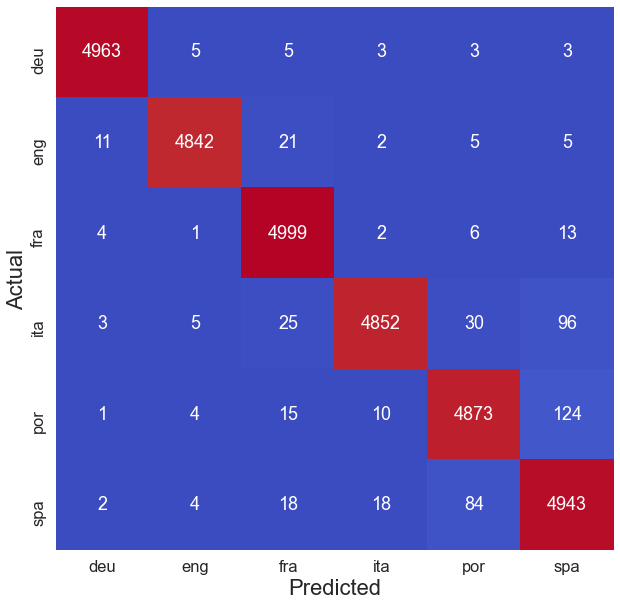

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']

labels = model.predict_classes(x_test)
predictions = encoder.inverse_transform(labels)

#Accuracy on test set
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

plt.savefig('../figures/model_eval.png',format='png',dpi=150)